### 機器學習百日馬拉松期中練習測驗

- 本賽題提供用戶在2016年1月1日至2016年5月31日之間真實線下消費行為，預測用戶在2016年6月領取優惠券後15天以內的使用情況。 
- [練習競賽網頁](https://www.kaggle.com/t/2eaf9a8ed13847cd9c26f05b2abfe966)
- [baseline kernel參考](https://www.kaggle.com/ml100marathon/baseline-example)

### History
- 2019-06-13 18:00 第一次提交：public score 0.57003，rank 136
- 2019-06-13 23:00 第二次提交：public score 0.60143，rank 86。把distance的補缺方式從一律填入眾數，改成以是否有購買商品時間分成兩組，各組的distance缺失值填入該組的distance平均值
- 2019-06-13       第四、五次提交。LRC + 把Merchant_id換算成各個Merchant_id出現的次數做為特徵，但並沒有變得比較好。
- 2019-06-13 15:12 第六次提交。RFC + 上述Merchant_id_cound，居然更爛，只有0.4333
- 2019-06-13 20:40 第七次提交。調整訓練與驗證資料集中,label 0與1的比例(原20:1, 改4:1),0.5905 好不到哪去
- 2019-06-13 20:52 第八次提交。承(七),改用GBM, 0.6551, rank 71
- 2019-06-13 21:00 第九次提交。承(八),但把訓練與驗證資料集中,label 0與1的比例從4:1改成1:1。0.66194, rank 61
- 2019-06-13 21:50 第十次提交。承(九),再加上一個新特徵discount_threshold。0.66944, rank 56

In [1]:
import numpy as np
import pandas as pd
import dateutil.parser as date_parser
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

### 檢視資料

In [2]:
# 檢視資料欄位描述

column_desc_df = pd.read_csv('data/midterm/column_description.csv', encoding = 'big5')
for i in column_desc_df.index:
    print('{:<30}\t{:<50}'.format(column_desc_df.ix[i][0], column_desc_df.ix[i][1]))

User_id                       	用戶 ID                                             
Merchant_id                   	商家 ID                                             
Coupon_id                     	優惠券 ID (null 代表無優惠券消費)                            
Discount_rate                 	優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元                 
Distance                      	用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 10 表示大於 5 公里。
Date_received                 	優惠券取得時間                                           
Date                          	購買商品時間 (如果 Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; 若為 Date is not null & Coupon_id is null, 則為普通消費日期; 若 Date is not null & Coupon_id is not null, 則表示優惠券消費日期)


In [3]:
# 檢視訓練資料
train_df = pd.read_csv('data/midterm/train_offline.csv', encoding = 'big5')
print(train_df.shape)
print(train_df.dtypes)
train_df.sample(n = 10)

(1160742, 7)
User_id            int64
Merchant_id        int64
Coupon_id        float64
Discount_rate     object
Distance         float64
Date_received    float64
Date             float64
dtype: object


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
288543,4742486,3381,11951.0,200:20,0.0,20160128.0,NaN
4451,1813430,2709,2840.0,100:10,10.0,20160126.0,NaN
392039,623068,3710,13056.0,150:10,4.0,20160207.0,NaN
747622,6058564,1379,NaN,NaN,1.0,NaN,20160419.0
52670,2011634,5341,11539.0,30:5,0.0,20160205.0,20160205.0
206095,6199769,2146,NaN,NaN,0.0,NaN,20160128.0
172179,5222033,7555,17.0,30:5,10.0,20160125.0,NaN
336072,5881087,4660,1480.0,100:10,10.0,20160123.0,NaN
285408,4206902,209,12368.0,100:10,5.0,20160125.0,NaN
222940,2508627,2934,5686.0,30:5,1.0,20160322.0,NaN


In [4]:
# 缺失值偵測

print('{:<25}\t{:>10}'.format('Column','isNa'))
print('-'*50)
for c in train_df.columns:
    print('{:<25}\t{:>10}'.format(c, np.unique(train_df[c].isna()).size > 1))

Column                   	      isNa
--------------------------------------------------
User_id                  	         0
Merchant_id              	         0
Coupon_id                	         1
Discount_rate            	         1
Distance                 	         1
Date_received            	         1
Date                     	         1


In [5]:
# 有購買商品時間者的平均距離
avg_distance_1 = np.ceil(train_df[~pd.isna(train_df['Date'])]['Distance'].mean())
# 無購買商品時間者的平均距離
avg_distance_2 = np.ceil(train_df[pd.isna(train_df['Date'])]['Distance'].mean())
#print(train_df[pd.isna(train_df['Distance']) & ~pd.isna(train_df['Date'])].shape)
print(avg_distance_1, avg_distance_2)

2.0 4.0


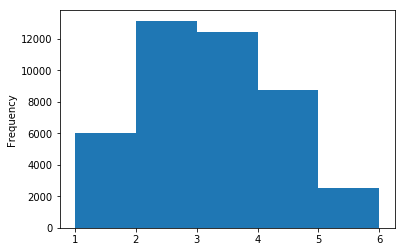

In [6]:
# 各月份使用優惠券消費的次數 (月份0者，代表無使用優惠券消費)
train_df['coupon_shoping_month'] = train_df[(np.isnan(train_df['Date']) == False) & (np.isnan(train_df['Coupon_id']) == False)]['Date'].apply(lambda d : int(str(int(d))[4:6]))
train_df['coupon_shoping_month'].fillna(0, inplace = True)
train_df['coupon_shoping_month'] = train_df['coupon_shoping_month'].astype('int')
train_df[train_df['coupon_shoping_month'] >0]['coupon_shoping_month'].plot.hist(bins=5)

### 處理缺失值

In [7]:
# Coupon_id, Date_received, Date 缺失者不處理
# Discount_rate 缺失者補上1.0
# Distance 缺失者補上平均值
train_df['Discount_rate'].fillna(1.0, inplace=True)
# 有購買商品時間者補值avg_distance_1 
train_df.loc[pd.isna(train_df['Distance']) & ~pd.isna(train_df['Date']), 'Distance'] = avg_distance_1
# 無購買商品時間者補值avg_distance_2
train_df.loc[pd.isna(train_df['Distance']) & pd.isna(train_df['Date']), 'Distance'] = avg_distance_2

### 特徵值處理與產生新特徵

- Merchant_id出現次數
- disconut_type

In [8]:
# 用Merchant_id出現次數,把它轉成另一種特徵
merchant_id_counts = train_df['Merchant_id'].value_counts()
train_df['merchant_count'] = train_df['Merchant_id'].apply(lambda m : merchant_id_counts[m])

In [9]:
# 產生新特徵: discount_type 共有兩種比例折(1)、滿額折(2)
def compute_discount_type_id(row):
    if ':' in str(row['Discount_rate']):
        return 2
    else:
        return 1
    
def compute_discount_type(df: pd.DataFrame):
    df['discount_type_id'] = df.apply(compute_discount_type_id, axis=1)   
    # 換成dummy variable
    discount_type_df = pd.get_dummies(df['discount_type_id'], 'discount_type')
    # 併入train_df
    df = pd.concat([df, discount_type_df], axis=1)
    return df

train_df = compute_discount_type(train_df)

In [10]:
# 產生新特徵: discount_threshold, 比例折(1)、滿額折(滿多少減多少的「滿」部份 )
def compute_discount_threshold(row):
    if ':' in str(row['Discount_rate']):
        return str(row['Discount_rate']).split(':')[0]
    else:
        return 1

train_df['discount_threshold'] = train_df.apply(compute_discount_threshold, axis=1)    

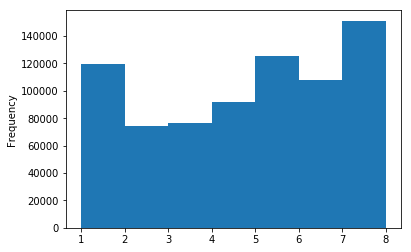

In [11]:
# 優惠券取得日期屬於星期幾(1 Monday - 7 Sunday)

# 用pd.to_datetime, 在macbook上要跑2分鐘
# train_df['Date_received_day_of_week'] = train_df[~np.isnan(train_df['Date_received'])]['Date_received'].apply(lambda d : pd.to_datetime(str(int(d)), format="%Y%m%d").weekday() + 1)
# 用dateutil.parser快多了！ 在macbook上不到5秒
def compute_received_day_of_week(df: pd.DataFrame):
    s = df[~np.isnan(df['Date_received'])]['Date_received'].apply(lambda d : date_parser.isoparse(str(int(d))).date().weekday() + 1)
    df['Date_received_day_of_week'] = s
    df['Date_received_day_of_week'].fillna(0, inplace = True)
    df['Date_received_day_of_week'] = df['Date_received_day_of_week'].astype(int)
    # 把優惠券取得日期星期幾換成dummy variable
    weekday_df = pd.get_dummies(df['Date_received_day_of_week'], 'Weekday')
    return pd.concat([df, weekday_df], axis=1)

train_df = compute_received_day_of_week(train_df)
train_df[train_df['Date_received_day_of_week'] > 0]['Date_received_day_of_week'].plot.hist(bins=range(1, 9))

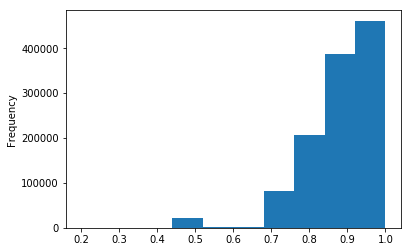

In [12]:
# 折扣率，原Discount_rate可能是小數(0.9)或比例(100:10 滿100減10,其實也等於九折)
def cnvt_discount_rate(rate_obj):
    rate_str = str(rate_obj)
    if rate_str == 'nan':
        return 1
    elif ':' in rate_str:
        _s = rate_str.split(':')
        return 1.0 - float(_s[1])/float(_s[0])
    else:
        return float(rate_str)

train_df['cnvt_discount_rate'] = train_df['Discount_rate'].apply(cnvt_discount_rate)
train_df['cnvt_discount_rate'].plot.hist()

### 產生標籤與訓練、驗證資料集

In [13]:
# 產生label
# 我們要學習的是：拿到優惠券的人，會不會在15天內使用，所以還要考慮Date與Date_received的差距
# 在所有資料中，只保留有拿優惠券者進行學習 （捨棄label = -1者）
#
# Date 購買商品時間
#   Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; label=0
#   Date is null & Coupon_id is null, 則該紀錄為沒有優惠券也沒有使用;  label=-1
#   Date is not null & Coupon_id is null, 則為普通消費日期;      label=-1
#   Date is not null & Coupon_id is not null, 則表示優惠券消費日期
#        Date - Date_received <= 15 , label=1
#                             else  , label=0

def compute_date_diff(date: str, date_received: str):
    return (date_parser.isoparse(date) - date_parser.isoparse(date_received)).days
    

def compute_label(row):
    if (np.isnan(row['Date_received'])):
        return -1
    if (~np.isnan(row['Date'])):
        if compute_date_diff(str(int(row['Date'])), str(int(row['Date_received']))) <= 15:
            return 1
        else:
            return 0
    else:
        return 0   
                                     
train_df['label'] = train_df.apply(compute_label, axis=1)
train_df['label'] = train_df['label'].astype(int)

train_df['label'].value_counts()
      

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [14]:
# 產生訓練與驗證資料集，只取label = 0或1者

weekday_features = ['Weekday_' + str(i) for i in range(1,8)]
discount_type_features = ['discount_type_1', 'discount_type_2']

features = ['cnvt_discount_rate','Distance', 'Date_received_day_of_week', 'merchant_count','discount_threshold']
# features = ['cnvt_discount_rate','Distance', 'merchant_count','discount_threshold']
features.extend(weekday_features)
features.extend(discount_type_features)

train_X = train_df[train_df['label'] >= 0][features].copy()
train_y = train_df[train_df['label'] >= 0]['label'].copy()

# 已知標籤裡，0 : 1 大約 20 : 1
# 若換成 2 : 1 來做訓練，不知有何不同

train_X_0 = train_df[train_df['label'] == 0][features].copy()
train_X_1 = train_df[train_df['label'] == 1][features].copy()
train_y_0 = train_df[train_df['label'] == 0]['label'].copy()
train_y_1 = train_df[train_df['label'] == 1]['label'].copy()

train_X_0 = train_X_0.sample(train_X_1.shape[0])
train_y_0 = train_y_0.sample(train_y_1.shape[0])

train_X = pd.concat([train_X_0, train_X_1], axis=0)
train_y = pd.concat([train_y_0, train_y_1], axis=0)

# scaler = StandardScaler()
# train_X = scaler.fit_transform(train_X)

train_train_X, test_train_X, train_train_y, test_train_y = train_test_split(train_X, train_y, 
                                                                            test_size=0.2, random_state = 42)

print(train_y.value_counts())

1    36304
0    36304
Name: label, dtype: int64


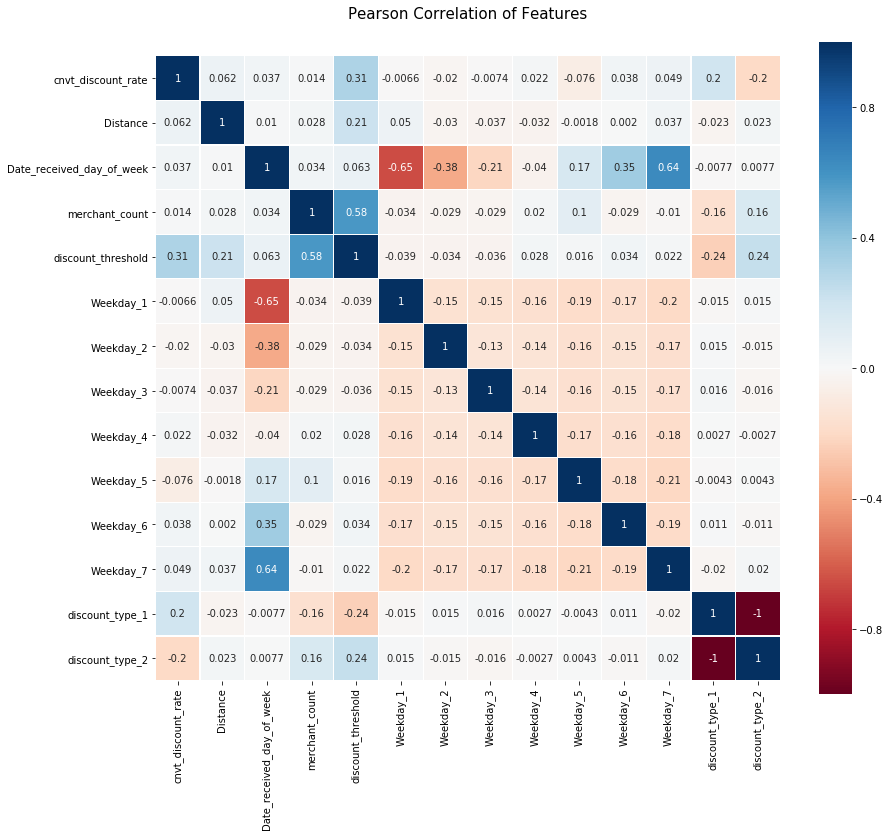

In [15]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_X.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### 模型訓練與驗證

In [16]:
# 隨機森林
rfc = RandomForestClassifier(max_features= 'sqrt' ,n_estimators=100)
rfc.fit(train_train_X, train_train_y)
# cross_val_score(rfc, train_train_X, train_train_y, cv=10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
# 梯度提升機
gbm = GradientBoostingClassifier(loss = 'deviance', learning_rate = 0.1, n_estimators = 100)
gbm.fit(train_train_X, train_train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
# 邏輯斯回歸
lrc = LogisticRegression()
lrc.fit(train_train_X, train_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
ve = VotingClassifier(estimators=[('gbm', gbm), ('lrv', lrc), ('rfc', rfc)], voting='soft')
ve.fit(train_train_X, train_train_y)

VotingClassifier(estimators=[('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1,...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [26]:
# 對測試集進行預測
clf = gbm

test_train_y_pred = clf.predict_proba(test_train_X)
print('AUC', roc_auc_score(test_train_y, test_train_y_pred[:, 1]))
print('Accuracy', accuracy_score(test_train_y, np.argmax(test_train_y_pred, axis=1)))

AUC 0.8793006541318085
Accuracy 0.8088417573337006


### 處理與預測測試資料

- 處理方式比對上述訓練資料
- 填補缺失值
- 轉換待徵
- 產生測試樣本
- 預期提交預測數是 304096
- 提交時發現驗證失敗，才知道原來User_id + Date_received + Coupon_id會重複
- 用df.drop_duplicate()解決上述問題，再次submit時又報錯：
```
ERROR: Unable to find 304096 required key values in the 'uid' column
ERROR: Unable to find the required key value '1000020_2705_20160519' in the 'uid' column
ERROR: Unable to find the required key value '1000020_8192_20160513' in the 'uid' column
ERROR: Unable to find the required key value '1000065_1455_20160527' in the 'uid' column
ERROR: Unable to find the required key value '1000085_8067_20160513' in the 'uid' column
ERROR: Unable to find the required key value '1000086_2418_20160613' in the 'uid' column
ERROR: Unable to find the required key value '1000140_8192_20160526' in the 'uid' column
ERROR: Unable to find the required key value '1000169_2418_20160606' in the 'uid' column
ERROR: Unable to find the required key value '1000297_13704_20160520' in the 'uid' column
ERROR: Unable to find the required key value '1000324_13165_20160526' in the 'uid' column
```

In [21]:
def compute_merchant_id_count(merchant_id):
    if merchant_id in merchant_id_counts:
        return merchant_id_counts[merchant_id]
    else:
        return 0

In [22]:
test_df = pd.read_csv('data/midterm/test_offline.csv')
test_df.sample(10)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
356167,4815507,2174,NaN,NaN,1.0,NaN
390020,518441,6792,10403.0,30:1,0.0,20160615.0
517029,3988367,3447,6922.0,50:10,0.0,20160614.0
48212,973587,797,12331.0,30:5,NaN,20160513.0
432970,2486806,4123,7180.0,50:5,0.0,20160607.0
394930,1308336,3546,NaN,NaN,1.0,NaN
384353,1255062,7150,3309.0,30:1,NaN,20160504.0
191305,249428,4663,11002.0,150:20,NaN,20160528.0
377861,1362054,6468,9972.0,20:5,2.0,20160506.0
123569,4986734,6530,12461.0,20:1,2.0,20160503.0


In [23]:
# 載入測試資料
test_df = pd.read_csv('data/midterm/test_offline.csv')

# 保留有Coupon_id者
test_df = test_df[~pd.isna(test_df['Coupon_id'])]
test_df.reset_index(drop=True, inplace=True)


# 轉換待徵:
#     優惠券取得日期屬於星期幾
test_df = compute_received_day_of_week(test_df)
#     Merchant_id count
test_df['merchant_count'] = test_df['Merchant_id'].apply(lambda m : compute_merchant_id_count(m))
#     discount_type
test_df = compute_discount_type(test_df)

# 填補缺失值
test_df['User_id'].fillna(0, inplace = True)
test_df['Merchant_id'].fillna(0, inplace = True)
test_df['merchant_count'].fillna(0, inplace = True)
test_df['Discount_rate'].fillna(1.0, inplace=True)
test_df['Distance'].fillna(test_df['Distance'].mean(), inplace=True)
test_df['Date_received'].fillna(0, inplace=True)

# 加上uid, 將 User_id - Date_received - Coupon_id 為一組計
test_df['uid'] = test_df.apply(lambda row : '{}_{}_{}'.format(int(row['User_id']), int(row['Coupon_id']), int(row['Date_received'])), axis=1)

# 折扣率
test_df['cnvt_discount_rate'] = test_df['Discount_rate'].apply(cnvt_discount_rate)
# 折扣門檻
test_df['discount_threshold'] = test_df.apply(compute_discount_threshold, axis=1)   

# 產生測試樣本
test_X = test_df[features].copy()
# scaler = StandardScaler()
# test_X = scaler.fit_transform(test_X)

# 進行預測
test_y_pred = clf.predict_proba(test_X)
submit_df = pd.DataFrame({'uid': test_df['uid'], 'label': test_y_pred[:, 1]})

# DataFrame.drop_duplicates(subset=None, keep='first', inplace=False)[source]
submit_df.drop_duplicates(subset='uid', keep='last', inplace = True)
print(submit_df.shape)
submit_df.to_csv('data/midterm/submit_{}.csv'.format(int(datetime.now().timestamp())), index = False)

(304096, 2)


###  備用區

In [ ]:
# 隨機森林
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2']
}
grid_rfc = GridSearchCV(rfc, param_grid, cv= 5)
grid_rfc.fit(train_train_X, train_train_y)
print(grid_rfc.best_params_)